In [1]:
import matplotlib.pyplot as pp
import pandas as pd
import numpy as np
import scipy.optimize as so
import seaborn as sb
sb.set()

In [2]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Load historical prices

In [24]:
def load_data():
    symbols = [ 'AAPL', 'MSFT', 'MMM', 'AMZN', 'GOOG', 'JPM', 'BBT']
    total_shares = { 'AAPL': 4443265000, 'MSFT': 7628805618, 'MMM': 575050655, 'AMZN': 495797220,
           'GOOG': 689687449, 'JPM': 3136484924, 'BBT': 766303490 }
    
    n = len(symbols)
    prices_out, caps_out = [], []
    for s in symbols:
        dataframe = pd.read_csv('%s.csv' % s, index_col=None, parse_dates=['Date'])
        prices = list(dataframe['Close'])[-530:] # trailing window 500 days
        prices_out.append(prices)
        caps_out.append(total_shares[s] * np.r_[prices]) # cap mishe tedade kole sahm * gheimata
    return symbols, prices_out, np.array(caps_out)

names, prices, caps = load_data()   
n = len(names)

In [25]:
pd.DataFrame(prices)

,0,1,2,3,4,5,6,7,8,9,...,520,521,522,523,524,525,526,527,528,529
0,150.550003,153.139999,154.229996,153.279999,154.119995,153.809998,154.479996,153.479996,155.389999,155.300003,...,236.410004,240.509995,239.960007,243.179993,243.580002,246.580002,249.050003,243.289993,243.259995,248.759995
1,73.260002,73.260002,73.849998,73.870003,74.489998,74.610001,74.260002,74.690002,75.970001,76.000000,...,137.410004,138.429993,136.369995,137.240005,139.940002,140.729996,144.190002,142.830002,144.610001,143.369995
2,210.729996,211.029999,209.479996,209.550003,209.899994,212.759995,214.570007,216.520004,216.369995,216.520004,...,163.100006,165.940002,167.539993,168.759995,161.889999,166.089996,169.059998,168.809998,168.369995,164.990005
3,939.789978,938.599976,950.869995,956.400024,961.349976,959.190002,957.099976,965.450012,980.849976,989.580017,...,1757.510010,1785.660034,1765.729980,1762.170044,1780.780029,1761.329956,1777.079956,1762.709961,1779.989990,1776.660034
4,920.969971,924.859985,944.489990,949.500000,959.109985,953.270020,957.789978,951.679993,969.960022,978.890015,...,1245.489990,1246.150024,1242.800049,1259.130005,1260.989990,1265.130005,1290.000000,1262.619995,1261.290039,1260.109985
5,94.120003,93.699997,95.180000,95.379997,95.510002,96.839996,97.349998,96.360001,97.089996,96.919998,...,120.559998,123.550003,124.790001,125.120003,125.029999,126.029999,126.510002,126.430000,125.730003,124.919998
6,45.330002,45.189999,46.080002,46.299999,46.939999,47.160000,46.880001,46.369999,47.619999,47.689999,...,52.669998,53.450001,53.470001,53.490002,53.049999,53.580002,54.000000,54.240002,53.680000,53.049999


## Estimate assets historical return and covariances

In [26]:
# Function takes historical stock prices together with market capitalizations and
# calculates weights, historical returns and historical covariances
def assets_historical_returns_and_covariances(prices):
    prices = matrix(prices)  # create numpy matrix from prices
    # create matrix of historical returns
    rows, cols = prices.shape
    returns = empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1
    # calculate returns
    expreturns = array([])
    for r in range(rows):
        expreturns = append(expreturns, numpy.mean(returns[r]))
    # calculate covariances
    covars = cov(returns)
    expreturns = (1 + expreturns) ** 265 - 1  # Annualize returns
    covars = covars * 265  # Annualize covariances
    return expreturns, covars

In [27]:
def optimize_frontier(R, C, rf):
    W = solve_weights(R, C, rf)
    tan_mean, tan_var = port_mean_var(W, R, C)  # calculate tangency portfolio
    front_mean, front_var = solve_frontier(R, C, rf)  # calculate efficient frontier
    # Weights, Tangency portfolio asset means and variances, Efficient frontier means and variances
    return Result(W, tan_mean, tan_var, front_mean, front_var)


# Given risk-free rate, assets returns and covariances, this function calculates
# weights of tangency portfolio with respect to sharpe ratio maximization
def solve_weights(R, C, rf):
    def fitness(W, R, C, rf):
        mean, var = port_mean_var(W, R, C)  # calculate mean/variance of the portfolio
        util = (mean - rf) / sqrt(var)  # utility = Sharpe ratio
        return 1 / util  # maximize the utility, minimize its inverse value
    n = len(R)
    W = ones([n]) / n  # start optimization with equal weights
    b_ = [(0., 1.) for i in range(n)]  # weights for boundaries between 0%..100%. No leverage, no shorting
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})  # Sum of weights must be 100%
    optimized = so.minimize(fitness, W, (R, C, rf), method='SLSQP', constraints=c_, bounds=b_)
    return optimized.x


# Given risk-free rate, assets returns and covariances, this function calculates
# mean-variance frontier and returns its [x,y] points in two arrays
def solve_frontier(R, C, rf):
    def fitness(W, R, C, r):
        # For given level of return r, find weights which minimizes portfolio variance.
        mean, var = port_mean_var(W, R, C) 
        penalty = 100 * abs(
            mean - r)  # Big penalty for not meeting stated portfolio return effectively serves as optimization constraint
        return var + penalty
       
    frontier_mean, frontier_var = [], []
    n = len(R)  # Number of assets in the portfolio
    for r in linspace(min(R), max(R), num=25):  # Iterate through the range of returns on Y axis
        W = ones([n]) / n  # start optimization with equal weights
        b_ = [(0, 1) for i in range(n)]
        c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
        optimized = so.minimize(fitness, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_)

        # add point to the efficient frontier [x,y] = [optimized.x, r]
        frontier_mean.append(r)
        frontier_var.append(port_var(optimized.x, C))
    return array(frontier_mean), array(frontier_var)


# Calculates portfolio mean return
def port_mean_return(W, R):
    return sum(R * W)

# Calculates portfolio variance of returns 
def port_var(W, C):
    return dot(dot(W, C), W)

# Combination of the two functions above - mean and variance of returns calculation
def port_mean_var(W, R, C):
    return port_mean_return(W, R), port_var(W, C)

In [28]:
class Result:
    def __init__(self, W, tan_mean, tan_var, front_mean, front_var):
        self.W=W
        self.tan_mean=tan_mean
        self.tan_var=tan_var
        self.front_mean=front_mean
        self.front_var=front_var

In [29]:
def display_assets(names, R, C, color='black'):
    scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color), grid(True)  # draw assets
    for i in range(n): 
        text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment='center', color=color) # draw labels

def display_frontier(result, label=None, color='black'):
    text(result.tan_var ** .5, result.tan_mean, '   tangent', verticalalignment='center', color=color)
    scatter(result.tan_var ** .5, result.tan_mean, marker='o', color=color), grid(True)
    plot(result.front_var ** .5, result.front_mean, label=label, color=color), grid(True)  # draw efficient frontier

In [30]:
prices = np.array(prices)

In [31]:
rf = 0.02  # Risk-free rate
equlibrium_budgets = []
equlibrium_budgets_ret = []
equlibrium_weights = []
equlibrium_stock = []
results = []
stocks = [0] * 7
budget = 1000000
equlibrium_budgets.append(0)
equlibrium_budgets_ret.append(0)
equlibrium_weights.append(0)
equlibrium_stock.append(0)
transaction_budget = budget
transactionCostFactor = 0.0001
output = '{}\t|\t'.format('day')
for name in names:
    output += '{} \t'.format(name)
output += '|\t{}'.format('Budget')
print(output)
print('-'*100)
print('{}\t|\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t|\t{}'.format(0,stocks[0], stocks[1], stocks[2], 
                                                          stocks[3], stocks[4], stocks[5],
                                                          stocks[6],
                                                          budget))

for i in range(13):
    start_idx = int((i*22) + -265)
    end_idx = int(start_idx - 265)
    R, C = assets_historical_returns_and_covariances(prices[:,end_idx:start_idx])
    Wm = array(caps[:, start_idx]) / sum(caps[:, start_idx]) # calculate market weights from capitalizations
    mean, var = port_mean_var(Wm, R, C)
    lmb = (mean - rf) / var  # Calculate risk aversion
    Pi = dot(dot(lmb, C), Wm)

    res = optimize_frontier(Pi, C, rf)
    results.append(res)
    current_prices = prices[:,(i*22)+265]
    current_budget = budget
    weights = res.W
    current_budget = budget
    transaction_budget = (current_budget + np.sum(current_prices*stocks))
    for index, (w, current_closed_price) in enumerate(zip(res.W, current_prices)):
        number_of_stock = int((w * transaction_budget)/current_closed_price)
        if number_of_stock > stocks[index]: # buy
            total_cost = (number_of_stock - stocks[index]) * current_closed_price
            budget -= total_cost
            budget -= (total_cost * transactionCostFactor)
        elif number_of_stock < stocks[index]: # sell
            total_cost = (stocks[index] - number_of_stock) * current_closed_price
            budget += total_cost
            budget -= (total_cost * transactionCostFactor)
        stocks[index] = number_of_stock
    print('{}\t|\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t|\t{}'.format(((i*22)+1),stocks[0], stocks[1], stocks[2], 
                                                          stocks[3], stocks[4], stocks[5],
                                                          stocks[6], 
                                                          budget))
    print('-'*100)
    print("Budget after selling all stocks of this day: ", budget + (stocks[0]*prices[0,(i*22)+265]) + 
          (stocks[1]*prices[1,(i*22)+265]) + (stocks[2]*prices[2,(i*22)+265]) + (stocks[3]*prices[3,(i*22)+265]) +
          (stocks[4]*prices[4,(i*22)+265]) + (stocks[5]*prices[5,(i*22)+265]) +
          (stocks[6]*prices[6,(i*22)+265]))
    equlibrium_budgets_ret.append(((budget + (stocks[0]*prices[0,(i*22)+265]) + (stocks[1]*prices[1,(i*22)+265]) +
          (stocks[2]*prices[2,(i*22)+265]) + (stocks[3]*prices[3,(i*22)+265]) +
          (stocks[4]*prices[4,(i*22)+265]) + (stocks[5]*prices[5,(i*22)+265]) +
          (stocks[6]*prices[6,(i*22)+265]))/1000000)-1)
    equlibrium_weights.append(weights)
    equlibrium_budgets.append(budget + (stocks[0]*prices[0,(i*22)+265]) + (stocks[1]*prices[1,(i*22)+265]) +
          (stocks[2]*prices[2,(i*22)+265]) + (stocks[3]*prices[3,(i*22)+265]) +
          (stocks[4]*prices[4,(i*22)+265]) + (stocks[5]*prices[5,(i*22)+265]) +
          (stocks[6]*prices[6,(i*22)+265]))
    equlibrium_stock.append((stocks[0], stocks[1], stocks[2], 
                                                          stocks[3], stocks[4], stocks[5],
                                                          stocks[6]))

day	|	AAPL 	MSFT 	MMM 	AMZN 	GOOG 	JPM 	BBT 	|	Budget
----------------------------------------------------------------------------------------------------
0	|	0	0	0	0	0	0	0	|	1000000
1	|	1111	2053	60	129	190	685	0	|	1388.3002941479085
----------------------------------------------------------------------------------------------------
Budget after selling all stocks of this day:  999900.1488151479
23	|	1100	2107	0	137	199	557	0	|	1278.3592551434076
----------------------------------------------------------------------------------------------------
Budget after selling all stocks of this day:  928739.8226201433
45	|	1098	2263	0	161	202	0	0	|	1141.4317539569133
----------------------------------------------------------------------------------------------------
Budget after selling all stocks of this day:  864193.2030189568
67	|	1172	2228	0	162	194	0	0	|	393.8956489055116
----------------------------------------------------------------------------------------------------
Budget after selli

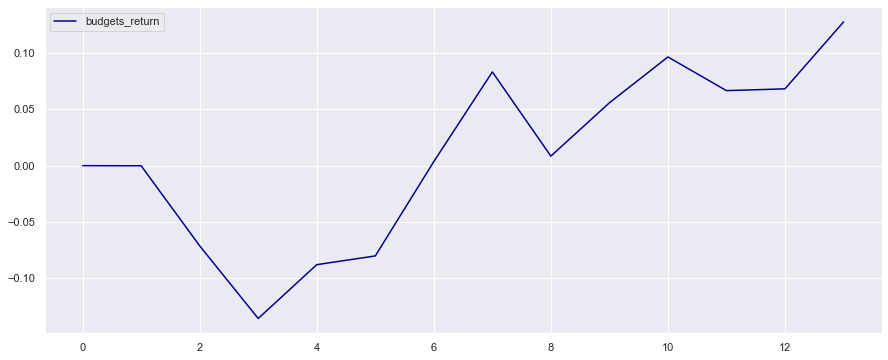

In [14]:
pp.figure(figsize=(15,6))
plt.plot(equlibrium_budgets_ret,color='darkblue')
pp.legend(['budgets_return'],loc='upper left')

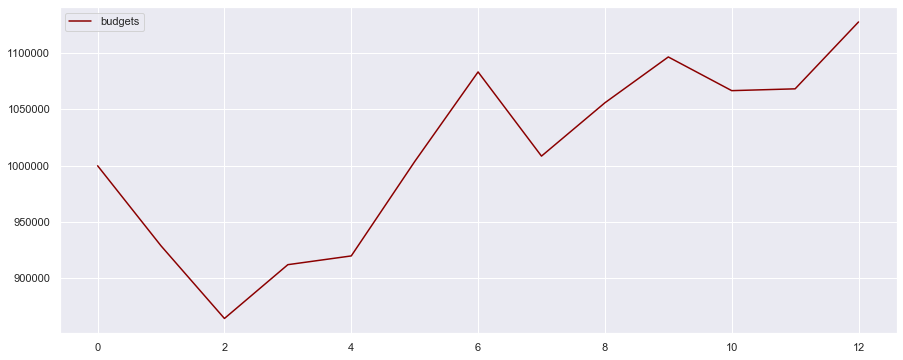

In [15]:
pp.figure(figsize=(15,6))
plt.plot(equlibrium_budgets[1:251],color='darkred')
pp.legend(['budgets'],loc='upper left')

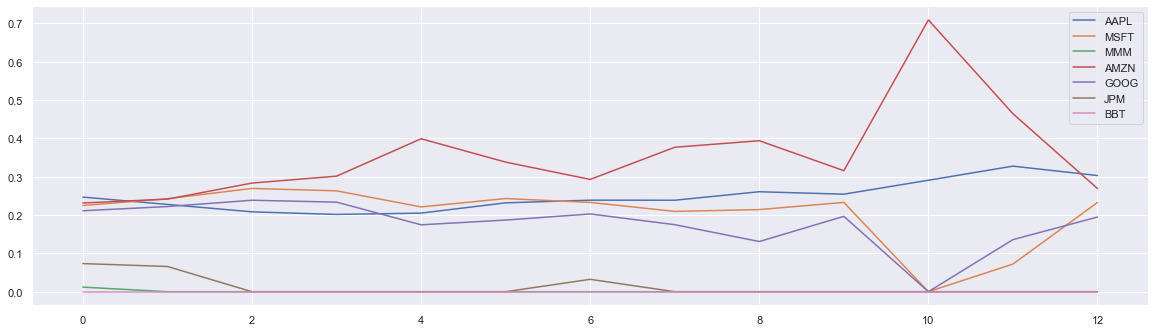

In [16]:
pp.figure(figsize=(20,5.5))
plt.plot(equlibrium_weights[1:251])
pp.legend([ 'AAPL', 'MSFT', 'MMM', 'AMZN', 'GOOG', 'JPM', 'BBT'])

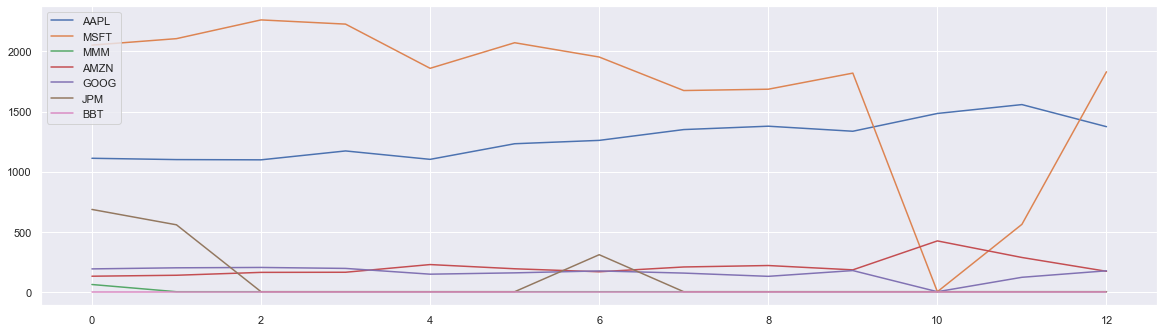

In [17]:
pp.figure(figsize=(20,5.5))
plt.plot(equlibrium_stock[1:251])
pp.legend([ 'AAPL', 'MSFT', 'MMM', 'AMZN', 'GOOG', 'JPM', 'BBT'])

In [18]:
pd.DataFrame(equlibrium_stock[1:251], columns=[ 'AAPL', 'MSFT', 'MMM', 'AMZN', 'GOOG', 'JPM', 'BBT'])

,AAPL,MSFT,MMM,AMZN,GOOG,JPM,BBT
0,1111,2053,60,129,190,685,0
1,1100,2107,0,137,199,557,0
2,1098,2263,0,161,202,0,0
3,1172,2228,0,162,194,0,0
4,1102,1860,0,226,146,0,0
5,1232,2073,0,191,157,0,0
6,1260,1954,0,166,173,308,0
7,1350,1675,0,206,155,0,0
8,1378,1686,0,218,128,0,0
9,1336,1820,0,182,176,0,0


In [19]:
pd.DataFrame(equlibrium_weights[1:251], columns=[ 'AAPL', 'MSFT', 'MMM', 'AMZN', 'GOOG', 'JPM', 'BBT'])

,AAPL,MSFT,MMM,AMZN,GOOG,JPM,BBT
0,0.246839,0.225054,1.192222e-02,0.231564,0.211258,7.336293e-02,0.000000e+00
1,0.227757,0.242686,0.000000e+00,0.241529,0.222215,6.581323e-02,2.818926e-18
2,0.208381,0.269488,0.000000e+00,0.283482,0.238649,1.802486e-18,0.000000e+00
3,0.201637,0.263189,0.000000e+00,0.301468,0.233707,0.000000e+00,0.000000e+00
4,0.205080,0.221270,2.116363e-16,0.399073,0.174577,0.000000e+00,0.000000e+00
5,0.231864,0.243080,0.000000e+00,0.338132,0.186924,4.906015e-18,1.476548e-17
6,0.238827,0.232989,1.355253e-18,0.293024,0.202823,3.233650e-02,0.000000e+00
7,0.238671,0.209541,1.431147e-17,0.376887,0.174901,0.000000e+00,0.000000e+00
8,0.260836,0.214290,4.748806e-17,0.393943,0.130932,0.000000e+00,0.000000e+00
9,0.254461,0.233027,0.000000e+00,0.315813,0.196698,1.951564e-18,4.228388e-18


In [20]:
pd.DataFrame(equlibrium_budgets_ret)

,0
0,0.000000
1,-0.000100
2,-0.071260
3,-0.135807
4,-0.087988
5,-0.080218
6,0.003608
7,0.083298
8,0.008492
9,0.055873


In [21]:
pd.DataFrame(equlibrium_budgets)

,0
0,0.000000e+00
1,9.999001e+05
2,9.287398e+05
3,8.641932e+05
4,9.120117e+05
5,9.197823e+05
6,1.003608e+06
7,1.083298e+06
8,1.008492e+06
9,1.055873e+06


In [21]:
Equlibrium_stock = pd.DataFrame(equlibrium_stock[1:251], columns=[ 'AAPL', 'MSFT', 'MMM', 'AMZN', 'GOOG', 'JPM', 'BBT'])
Equlibrium_stock.to_excel (r'D:\equlibrium_stock.xlsx', index = True, header=True)

In [22]:
Equlibrium_weights = pd.DataFrame(equlibrium_weights[1:251], columns=[ 'AAPL', 'MSFT', 'MMM', 'AMZN', 'GOOG', 'JPM', 'BBT'])
Equlibrium_weights.to_excel (r'D:\equlibrium_weights.xlsx', index = True, header=True)

In [24]:
Equlibrium_budgets_ret = pd.DataFrame(equlibrium_budgets_ret)
Equlibrium_budgets_ret.to_excel (r'D:\equlibrium_budgets_ret.xlsx', index = True, header=True)

In [25]:
Equlibrium_budgets = pd.DataFrame(equlibrium_budgets)
Equlibrium_budgets.to_excel (r'D:\equlibrium_budgets.xlsx', index = True, header=True)